# Random forest of anxiety on the student mental

## Introduction
The main objetive of this notebook it is to create a random forest model capable of predict if a given student have panic attack.

Lesson 5 - Student 190011611

Github: ciro-c


In this notebook, we're going to create Random Forests
The dataset we are going to use to train our model is [Student Mental health](https://www.kaggle.com/datasets/shariful07/student-mental-health/data)

We'll start by importing the basic set of libraries we normally need for data science work, and setting numpy to use our display space more efficiently:

In [1]:
from fastai.imports import *
np.set_printoptions(linewidth=130)

## Data preprocessing

We'll create `DataFrame`s from the CSV files

In [86]:
import os
iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')

if iskaggle: path = Path('../input/student-mental-health')
else:
    import zipfile,kaggle
    path = Path('student-mental-health')
    kaggle.api.competition_download_cli(str(path))
    zipfile.ZipFile(f'{path}.zip').extractall(path)

df = pd.read_csv(path/'Student Mental health.csv')
modes = df.mode().iloc[0]

Lets see our data

In [87]:
df.head(5)

,Timestamp,Choose your gender,Age,What is your course?,Your current year of Study,What is your CGPA?,Marital status,Do you have Depression?,Do you have Anxiety?,Do you have Panic attack?,Did you seek any specialist for a treatment?
0,8/7/2020 12:02,Female,18.0,Engineering,year 1,3.00 - 3.49,No,Yes,No,Yes,No
1,8/7/2020 12:04,Male,21.0,Islamic education,year 2,3.00 - 3.49,No,No,Yes,No,No
2,8/7/2020 12:05,Male,19.0,BIT,Year 1,3.00 - 3.49,No,Yes,Yes,Yes,No
3,8/7/2020 12:06,Female,22.0,Laws,year 3,3.00 - 3.49,Yes,Yes,No,No,No
4,8/7/2020 12:13,Male,23.0,Mathemathics,year 4,3.00 - 3.49,No,No,No,No,No


The column timestamp it means nothing to our goal. So we are going to exclude it and change the columns names to be more easy to manipulate

In [88]:
df.drop('Timestamp', axis=1, inplace=True)
new_columns = ['Gender','Age','Major','Year','CGPA','Marriage','Depression','Anxiety','Panic','Treatment']
df.columns = new_columns
df.head(5)

,Gender,Age,Major,Year,CGPA,Marriage,Depression,Anxiety,Panic,Treatment
0,Female,18.0,Engineering,year 1,3.00 - 3.49,No,Yes,No,Yes,No
1,Male,21.0,Islamic education,year 2,3.00 - 3.49,No,No,Yes,No,No
2,Male,19.0,BIT,Year 1,3.00 - 3.49,No,Yes,Yes,Yes,No
3,Female,22.0,Laws,year 3,3.00 - 3.49,Yes,Yes,No,No,No
4,Male,23.0,Mathemathics,year 4,3.00 - 3.49,No,No,No,No,No


Now lets change Major and Year lines to upper case

In [89]:
df['Year'] = df['Year'].str.upper()
df['Major'] = df['Major'].str.upper()

The CGPA column has two values that represents the same thing, lets fix it

In [90]:
df['CGPA'].unique()

array(['3.00 - 3.49', '3.50 - 4.00', '3.50 - 4.00 ', '2.50 - 2.99', '2.00 - 2.49', '0 - 1.99'], dtype=object)

In [91]:
df['CGPA'] = df['CGPA'].map({'3.00 - 3.49':'3.00 - 3.49', '3.50 - 4.00':'3.50 - 4.00', '3.50 - 4.00 ':'3.50 - 4.00', '2.50 - 2.99':'2.50 - 2.99', '2.00 - 2.49': '2.00 - 2.49', '0 - 1.99': '0 - 1.99'})
df['CGPA'].unique()

array(['3.00 - 3.49', '3.50 - 4.00', '2.50 - 2.99', '2.00 - 2.49', '0 - 1.99'], dtype=object)

Checking for dupplicates and treating null or missing values


In [74]:
# Missing values
df.isna().sum()

Gender        0
Age           1
Major         0
Year          0
CGPA          0
Marriage      0
Depression    0
Anxiety       0
Panic         0
Treatment     0
dtype: int64

In [92]:
#Dropping missing values
df.dropna(inplace=True)
df.isna().sum()

Gender        0
Age           0
Major         0
Year          0
CGPA          0
Marriage      0
Depression    0
Anxiety       0
Panic         0
Treatment     0
dtype: int64

In [93]:
#Current number of lines 
df.shape[0]


100

One difference with Random Forests however is that we don't generally have to create *dummy variables* like we did for non-numeric columns in the linear models and neural network. Instead, we can just convert those fields to *categorical variables*, which internally in Pandas makes a list of all the unique values in the column, and replaces each value with a number. The number is just an index for looking up the value in the list of all unique values.

In [94]:
df['Marriage'] = pd.Categorical(df.Marriage)
df['Depression'] = pd.Categorical(df.Depression)
df['Panic'] = pd.Categorical(df.Panic)
df['Treatment'] = pd.Categorical(df.Treatment)
df['Gender'] = pd.Categorical(df.Gender)
df['CGPA'] = pd.Categorical(df.CGPA)
df['Year'] = pd.Categorical(df.Year)
df['Major'] = pd.Categorical(df.Major)

We'll make a list of the continuous, categorical, and dependent variables. Note that we no longer consider `Pclass` a categorical variable. That's because it's *ordered* (i.e 1st, 2nd, and 3rd class have an order), and decision trees, as we'll see, only care about order, not about absolute value.

In [95]:
cats=["Marriage","Major","Depression","Panic","Treatment","Gender","CGPA","Year"]
conts=['Age']
dep="Anxiety"

Even although we've made the `cats` columns categorical, they are still shown by Pandas as their original values:

In [96]:
df.Gender.head()

0    Female
1      Male
2      Male
3    Female
4      Male
Name: Gender, dtype: category
Categories (2, object): ['Female', 'Male']

However behind the scenes they're now stored as integers, with indices that are looked up in the `Categories` list shown in the output above. We can view the stored values by looking in the `cat.codes` attribute:

Transforming the result we whant in int

In [98]:
df['Anxiety'] = df['Anxiety'].map({'Yes': 1, 'No': 0})

## Data analisys

Text(0, 0.5, 'Frequency')

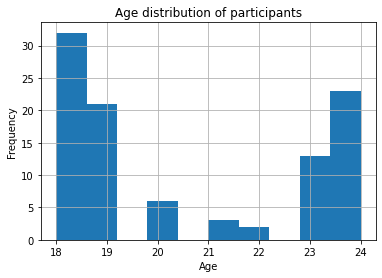

In [99]:
import matplotlib.pyplot as plt
import numpy as np

df['Age'].hist()
plt.title('Age distribution of participants')
plt.xlabel('Age')
plt.ylabel('Frequency')

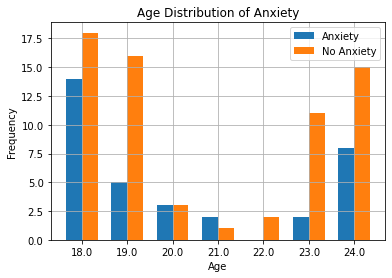

In [100]:
df_anxiety = df[df['Anxiety'] == 1]
df_no_anxiety = df[df['Anxiety'] == 0]
# Count the ages
anxiety_counts = df_anxiety['Age'].value_counts().sort_index()
no_anxiety_counts = df_no_anxiety['Age'].value_counts().sort_index()

# Ensure that the counts for each age group are the same
ages = anxiety_counts.index.union(no_anxiety_counts.index)
anxiety_counts = anxiety_counts.reindex(ages, fill_value=0)
no_anxiety_counts = no_anxiety_counts.reindex(ages, fill_value=0)

# Create the distribution graph
width = 0.35
x = np.arange(len(ages))

plt.bar(x - width/2, anxiety_counts, width, label='Anxiety')
plt.bar(x + width/2, no_anxiety_counts, width, label='No Anxiety')

plt.xticks(x, ages)
plt.title('Age Distribution of Anxiety')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)
plt.show()

In [48]:
# Has anxiety
df[df['Anxiety'] == 'Yes'].shape[0]

34

In [49]:
# Don't have anxiety
df[df['Anxiety'] == 'No'].shape[0]

66

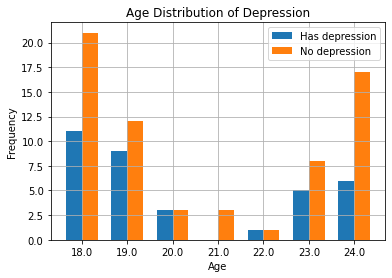

In [50]:
df_depressed = df[df['Depression'] == 'Yes']
df_no_depressed = df[df['Depression'] == 'No']
# Count the ages
depressed_counts = df_depressed['Age'].value_counts().sort_index()
no_depressed_counts = df_no_depressed['Age'].value_counts().sort_index()

# Ensure that the counts for each age group are the same
ages = depressed_counts.index.union(no_depressed_counts.index)
depressed_counts = depressed_counts.reindex(ages, fill_value=0)
no_depressed_counts = no_depressed_counts.reindex(ages, fill_value=0)

# Create the distribution graph
width = 0.35
x = np.arange(len(ages))

plt.bar(x - width/2, depressed_counts, width, label='Has depression')
plt.bar(x + width/2, no_depressed_counts, width, label='No depression')

plt.xticks(x, ages)
plt.title('Age Distribution of Depression')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)
plt.show()


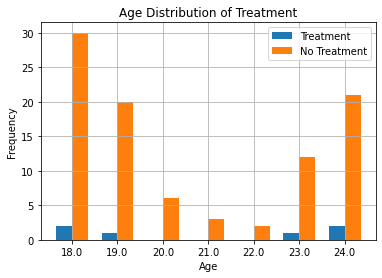

In [52]:
df_treatment = df[df['Treatment'] == 'Yes']
df_no_treatment = df[df['Treatment'] == 'No']
# Count the ages
treatment_counts = df_treatment['Age'].value_counts().sort_index()
no_treatment_counts = df_no_treatment['Age'].value_counts().sort_index()

# Ensure that the counts for each age group are the same
ages = treatment_counts.index.union(no_treatment_counts.index)
treatment_counts = treatment_counts.reindex(ages, fill_value=0)
no_treatment_counts = no_treatment_counts.reindex(ages, fill_value=0)

# Create the distribution graph
width = 0.35
x = np.arange(len(ages))

plt.bar(x - width/2, treatment_counts, width, label='Treatment')
plt.bar(x + width/2, no_treatment_counts, width, label='No Treatment')

plt.xticks(x, ages)
plt.title('Age Distribution of Treatment')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)
plt.show()


## Binary splits

Before we create a Random Forest or Gradient Boosting Machine, we'll first need to learn how to create a *decision tree*, from which both of these models are built.

And to create a decision tree, we'll first need to create a *binary split*, since that's what a decision tree is built from.

A binary split is where all rows are placed into one of two groups, based on whether they're above or below some threshold of some column. For example, we could split the rows of our dataset into males and females, by using the threshold `0.5` and the column `Gender` (since the values in the column are `0` for `female` and `1` for `male`). We can use a plot to see how that would split up our data -- we'll use the [Seaborn](https://seaborn.pydata.org/) library, which is a layer on top of [matplotlib](https://matplotlib.org/) that makes some useful charts easier to create, and more aesthetically pleasing by default:

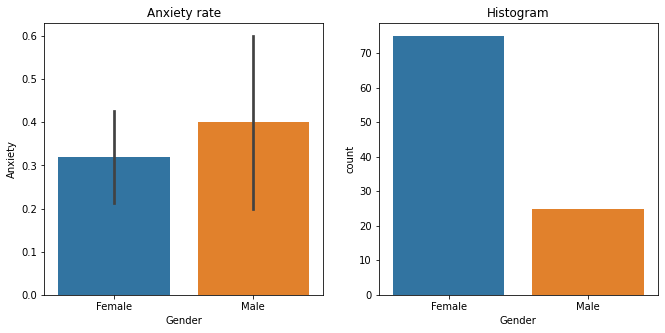

In [101]:
import seaborn as sns

fig,axs = plt.subplots(1,2, figsize=(11,5))
sns.barplot(data=df, y=dep, x="Gender", ax=axs[0]).set(title="Anxiety rate")
sns.countplot(data=df, x="Gender", ax=axs[1]).set(title="Histogram");

## Dividing data

In [103]:
from numpy import random
from sklearn.model_selection import train_test_split

random.seed(42)
trn_df,val_df = train_test_split(df, test_size=0.25)
trn_df[cats] = trn_df[cats].apply(lambda x: x.cat.codes)
val_df[cats] = val_df[cats].apply(lambda x: x.cat.codes)

(In the previous step we also replaced the categorical variables with their integer codes, since some of the models we'll be building in a moment require that.)

Now we can create our independent variables (the `x` variables) and dependent (the `y` variable):

In [104]:
def xs_y(df):
    xs = df[cats+conts].copy()
    return xs,df[dep] if dep in df else None

trn_xs,trn_y = xs_y(trn_df)
val_xs,val_y = xs_y(val_df)

Here's the predictions for our extremely simple model, where `female` is coded as `0`:

In [108]:
preds = val_xs.Gender==0

We'll use mean absolute error to measure how good this model is:

In [109]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(val_y, preds)

0.72

In [120]:
preds = val_xs.Age>18
mean_absolute_error(val_y, preds)

0.68

This is quite a bit less accurate than our model that used `Sex` as the single binary split.

Ideally, we'd like some way to try more columns and breakpoints more easily. We could create a function that returns how good our model is, in order to more quickly try out a few different splits. We'll create a `score` function to do this. Instead of returning the mean absolute error, we'll calculate a measure of *impurity* -- that is, how much the binary split creates two groups where the rows in a group are each similar to each other, or dissimilar.

We can measure the similarity of rows inside a group by taking the standard deviation of the dependent variable. If it's higher, then it means the rows are more different to each other. We'll then multiply this by the number of rows, since a bigger group as more impact than a smaller group:

In [111]:
def _side_score(side, y):
    tot = side.sum()
    if tot<=1: return 0
    return y[side].std()*tot

Now we've got that written, we can calculate the score for a split by adding up the scores for the "left hand side" (lhs) and "right hand side" (rhs):

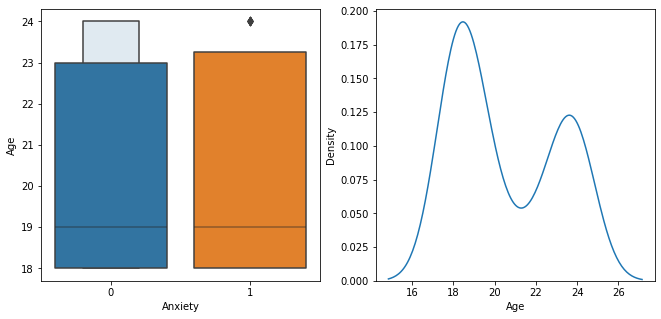

In [115]:
df_fare = trn_df[trn_df.Age>0]
fig,axs = plt.subplots(1,2, figsize=(11,5))
sns.boxenplot(data=df_fare, x=dep, y="Age", ax=axs[0])
sns.kdeplot(data=df_fare, x="Age", ax=axs[1]);

In [112]:
    
def score(col, y, split):
    lhs = col<=split
    return (_side_score(lhs,y) + _side_score(~lhs,y))/len(y)

For instance, here's the impurity score for the split on `Sex`:

In [113]:
score(trn_xs["Gender"], trn_y, 0.5)

0.4903411775065181

...and for `Age`:

In [116]:
score(trn_xs["Age"], trn_y, 18)

0.48661751629257244

In [117]:
score(trn_xs["Age"], trn_y, 24)

0.4869467292395721

Find the lowest score of age


In [121]:
nm = "Age"
col = trn_xs[nm]
unq = col.unique()
unq.sort()
scores = np.array([score(col, trn_y, o) for o in unq if not np.isnan(o)])
unq[scores.argmin()]

18.0

Based on this, it looks like, for instance, that for the `Age` column, `18` is the optimal cutoff according to our training set.

We can write a little function that implements this idea:

In [125]:
def min_col(df, nm):
    col,y = df[nm],df[dep]
    unq = col.dropna().unique()
    scores = np.array([score(col, y, o) for o in unq if not np.isnan(o)])
    idx = scores.argmin()
    return unq[idx],scores[idx]

min_col(trn_df, "Age")

(18.0, 0.48661751629257244)

Let's try all the columns:

In [126]:
cols = cats+conts
{o:min_col(trn_df, o) for o in cols}

{'Marriage': (1, 0.4869467292395721),
 'Major': (2, 0.47128233815147497),
 'Depression': (0, 0.4583187346545716),
 'Panic': (0, 0.48579390461299266),
 'Treatment': (1, 0.4869467292395721),
 'Gender': (1, 0.4869467292395721),
 'CGPA': (1, 0.47128233815147497),
 'Year': (3, 0.4869467292395721),
 'Age': (18.0, 0.48661751629257244)}

According to this, `Depression<=0` is the best split we can use.

We've just re-invented the [OneR](https://link.springer.com/article/10.1023/A:1022631118932) classifier (or at least, a minor variant of it), which was found to be one of the most effective classifiers in real-world datasets, compared to the algorithms in use in 1993. Since it's so simple and surprisingly effective, it makes for a great *baseline* -- that is, a starting point that you can use to compare your more sophisticated models to.

We found earlier that out OneR rule had an error of around `0.215`, so we'll keep that in mind as we try out more sophisticated approaches.

## Creating a decision tree

First, we'll remove `Depression` from the list of possible splits (since we've already used it, and there's only one possible split for that binary column), and create our two groups:

In [130]:
cols.remove("Depression")
isdepressed = trn_df.Depression==1
depressed,no_depressed = trn_df[isdepressed],trn_df[~isdepressed]

Now let's find the single best binary split for depressed...:

In [131]:
{o:min_col(depressed, o) for o in cols}

{'Marriage': (0, 0.48468282404963065),
 'Major': (36, 0.4714476364010172),
 'Panic': (0, 0.4934230319156472),
 'Treatment': (1, 0.5012300141587652),
 'Gender': (1, 0.5012300141587652),
 'CGPA': (4, 0.5012300141587652),
 'Year': (2, 0.4865749537590052),
 'Age': (18.0, 0.4982887251445705)}

...and for no_depressed:

In [132]:
{o:min_col(no_depressed, o) for o in cols}

{'Marriage': (0, 0.4312659714888844),
 'Major': (20, 0.407847470050303),
 'Panic': (1, 0.4312659714888844),
 'Treatment': (0, 0.4312659714888844),
 'Gender': (1, 0.4312659714888844),
 'CGPA': (2, 0.4063049137937364),
 'Year': (3, 0.4312659714888844),
 'Age': (24.0, 0.4312659714888844)}

We can see that the best next binary split for depressed is `Manjor<=36`, and for no_depressed is `CGPA<=2`.

By adding these rules, we have created a *decision tree*, where our model will first check whether `Depression` is no_depressed or depressed, and depending on the result will then check either the above `Major` or `CGPA` rules, as appropriate. We could then repeat the process, creating new additional rules for each of the four groups we've now created.

Rather than writing that code manually, we can use `DecisionTreeClassifier`, from *sklearn*, which does exactly that for us:

In [225]:
from sklearn.tree import DecisionTreeClassifier, export_graphviz

m = DecisionTreeClassifier(max_leaf_nodes=15).fit(trn_xs, trn_y);

One handy feature or this class is that it provides a function for drawing a tree representing the rules:

In [227]:
import graphviz

def draw_tree(t, df, size=10, ratio=0.6, precision=25, **kwargs):
    s=export_graphviz(t, out_file=None, feature_names=df.columns, filled=True, rounded=True,
                      special_characters=True, rotate=False, precision=precision, **kwargs)
    return graphviz.Source(re.sub('Tree {', f'Tree {{ size={size}; ratio={ratio}', s))

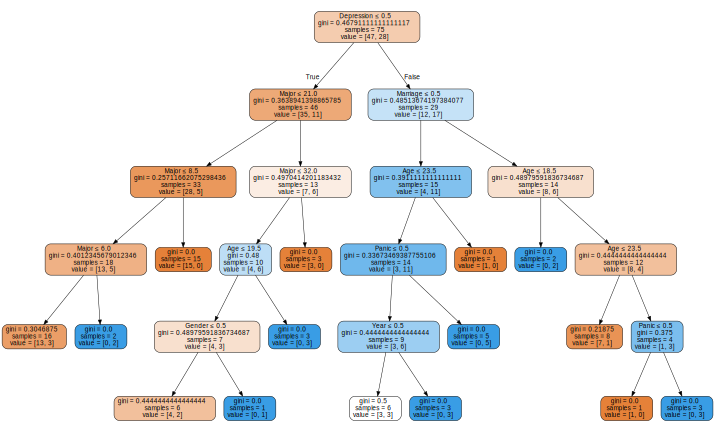

In [228]:
draw_tree(m, trn_xs, size=10)

We can see that it's found exactly the same splits as we did!

In this picture, the more orange nodes have a lower survival rate, and blue have higher survival. Each node shows how many rows ("*samples*") match that set of rules, and shows how many perish or survive ("*values*"). There's also something called "*gini*". That's another measure of impurity, and it's very similar to the `score()` we created earlier. It's defined as follows:

In [155]:
def gini(cond):
    act = df.loc[cond, dep]
    return 1 - act.mean()**2 - (1-act).mean()**2

What this calculates is the probability that, if you pick two rows from a group, you'll get the same `Survived` result each time. If the group is all the same, the probability is `1.0`, and `0.0` if they're all different:

In [161]:
gini(df.Depression=='No'), gini(df.Depression=='Yes')

(0.37112426035502954, 0.49959183673469393)

Let's see how this model compares to our OneR version:

In [230]:
mean_absolute_error(val_y, m.predict(val_xs))
#best values leafs node 15, 21, 28 => error 0.32

0.32

now with a bigger tree

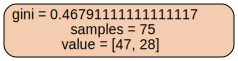

In [231]:
m = DecisionTreeClassifier(min_samples_leaf=50)
m.fit(trn_xs, trn_y)
draw_tree(m, trn_xs, size=12)

In [232]:
mean_absolute_error(val_y, m.predict(val_xs))

0.24

## The random forest

We can't make the decision tree much bigger than the example above, since some leaf nodes already have only 50 rows in them. That's not a lot of data to make a prediction.

So how could we use bigger trees? One big insight came from Leo Breiman: what if we create lots of bigger trees, and take the average of their predictions? Taking the average prediction of a bunch of models in this way is known as [bagging](https://link.springer.com/article/10.1007/BF00058655).

The idea is that we want each model's predictions in the averaged ensemble to be uncorrelated with each other model. That way, if we average the predictions, the average will be equal to the true target value -- that's because the average of lots of uncorrelated random errors is zero. That's quite an amazing insight!

One way we can create a bunch of uncorrelated models is to train each of them on a different random subset of the data. Here's how we can create a tree on a random subset of the data:

In [233]:
def get_tree(prop=0.75):
    n = len(trn_y)
    idxs = random.choice(n, int(n*prop))
    return DecisionTreeClassifier(min_samples_leaf=5).fit(trn_xs.iloc[idxs], trn_y.iloc[idxs])

Now we can create as many trees as we want:

In [242]:
trees = [get_tree() for t in range(100)]

Our prediction will be the average of these trees' predictions:

In [246]:
all_probs = [t.predict(val_xs) for t in trees]
avg_probs = np.stack(all_probs).mean(0)

mean_absolute_error(val_y, avg_probs)

0.44160000000000005

This is nearly identical to what `sklearn`'s `RandomForestClassifier` does. The main extra piece in a "real" random forest is that as well as choosing a random sample of data for each tree, it also picks a random subset of columns for each split. Here's how we repeat the above process with a random forest:

In [247]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(100, min_samples_leaf=10)
rf.fit(trn_xs, trn_y);
mean_absolute_error(val_y, rf.predict(val_xs))

0.24

I found that gave nearly an identical result as our single tree (which, in turn, was slightly lower than our linear and neural net models in the previous notebook).

One particularly nice feature of random forests is they can tell us which independent variables were the most important in the model, using `feature_importances_`:

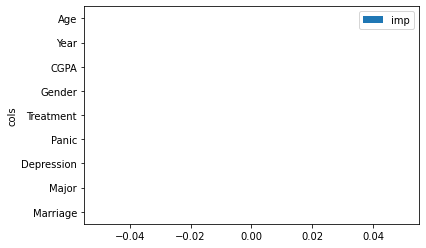

In [248]:
pd.DataFrame(dict(cols=trn_xs.columns, imp=m.feature_importances_)).plot('cols', 'imp', 'barh');

I gave nothing important 

## Conclusion

I think this data set is too small to get anything conclusive, but the tree generated it performed better than the linear model

## Saving our random forest

In [250]:
import joblib
filename = 'anxiousAmazon.sav'
joblib.dump(rf, filename)

['anxiousAmazon.sav']